<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling/blob/main/Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Connection and Packages Importation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sn

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **CNN(Convolutional Neural Network), 합성곱신경망**  


---


*Architecture of CNN = Convolutional Layer -> Activation Layer -> Pooling Layer -> Fully-Connected Layer*  
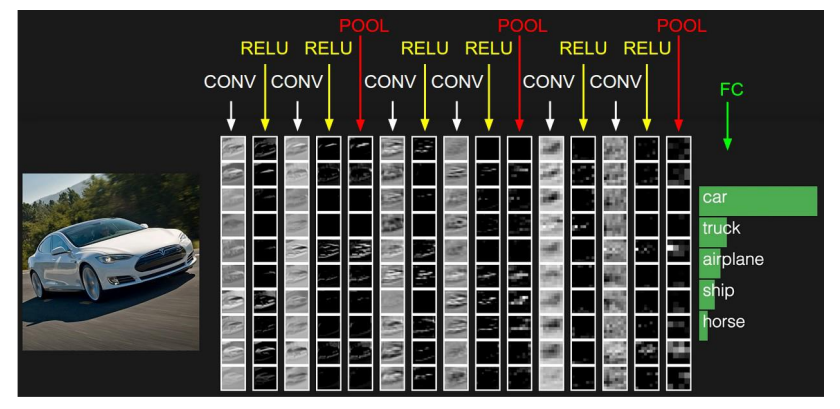  
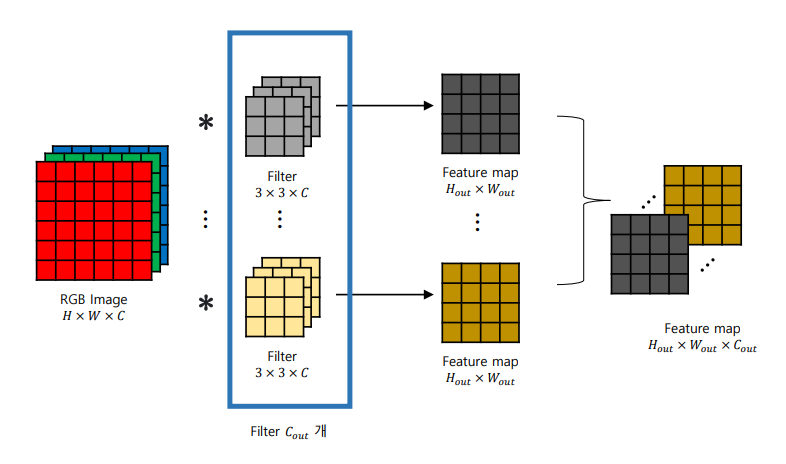
> **① Convolutional Layer**  
> Convolution Filter를 parameter로 갖는 layer, Input data(Cin X Win X Hin)와 Conv Filter(Cin, Cout, Hc, Wc)의 Convolution 연산으로 Output data(Cout X Wout X Hout)을 형성  
>  
>
> **② Acivation Layer**  
> Convolution 연산으로 생성된 Output data(=Feature map)에 대해 Activation Function을 통과하는 layer  
>  
>
> **③ Pooling Layer**  
> Feature map의 spatial size를 줄이는 layer로, 보통 연속되는 Conv Layer들 사이에 반복적으로 삽입  
>  
>
> **④ Fully-Connected Layer**  
> Conv Layer와 Pooling Layer의 반복으로 형성된 High Level 3-Dim feature에 대해, 이를 Vectorize하여 Fully-Connected Layer로 Encoding, 마지막 FC Layer에서 class의 갯수만큼 Output vector 설정

## **Max Pooling, Paddding과 Stride에 따른 Feature map의 변화**  


---


- **Max Pooling :** 가장 일반적으로 많이 사용하는 Pooling 기법으로, 일정 Area 내 가장 큰 값을 대푯값으로 삼아 Feature map을 요약하는 방법  
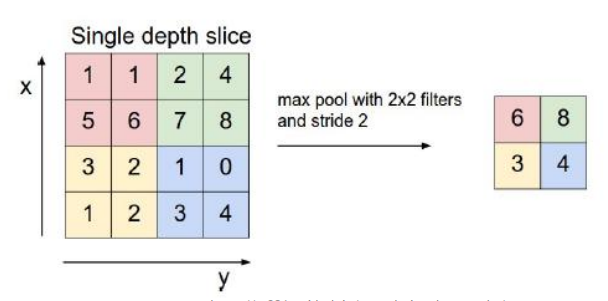
- **Feature map의 변화 :** Input data의 width와 height에 대해, Conv Filter를 지나고 나면 Padding size와 Stride size에 의해 Spatial Size가 변화  
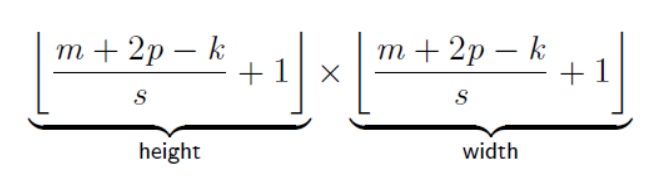

## **MNIST and SVHN Dataset Preparation**  
- MNIST : 흑백 손글씨 "1 X 28 X 28" Image data set  
- SVHN : MNIST와 유사하지만, Colorized Street View House Number data set, "3 X 32 X 32 RGB" Image data set

In [ ]:
# Setting Directory path
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
print(root)

# Define Plot MNIST data set
def plot_image_mnist(data, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    image = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(image.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label : {data[i][1]}")
  fig.show()

# Define Plot SVHN data set
def plot_image_svhn(data, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(9):
    image = data[i][0]
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Label : {data[i][1]}")
  fig.show()

/content/drive/MyDrive/Colab Notebooks/data


torch.Size([60000]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


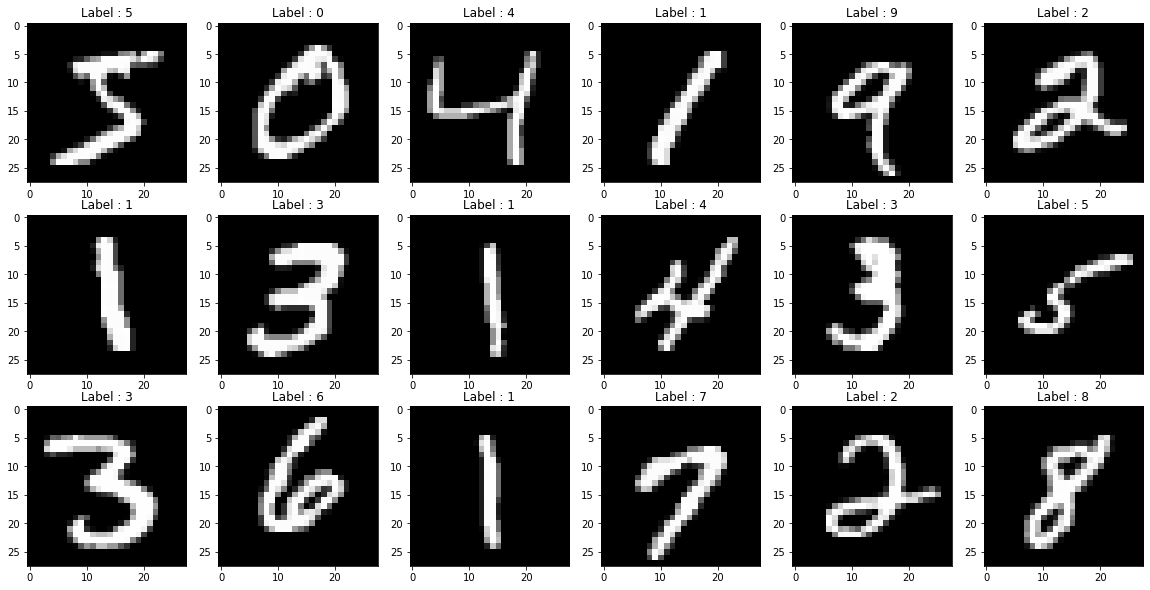

In [ ]:
## MNIST Data set Preparation
mnist_train = datasets.MNIST(         # MNIST Training data set
    root=root,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(          # MNIST Test data set
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print(mnist_train.targets.shape, mnist_train.targets.unique())
plot_image_mnist(data=mnist_train)

Using downloaded and verified file: /content/drive/MyDrive/Colab Notebooks/data/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/Colab Notebooks/data/test_32x32.mat
Input Length = 73257   Class labels = [0 1 2 3 4 5 6 7 8 9]


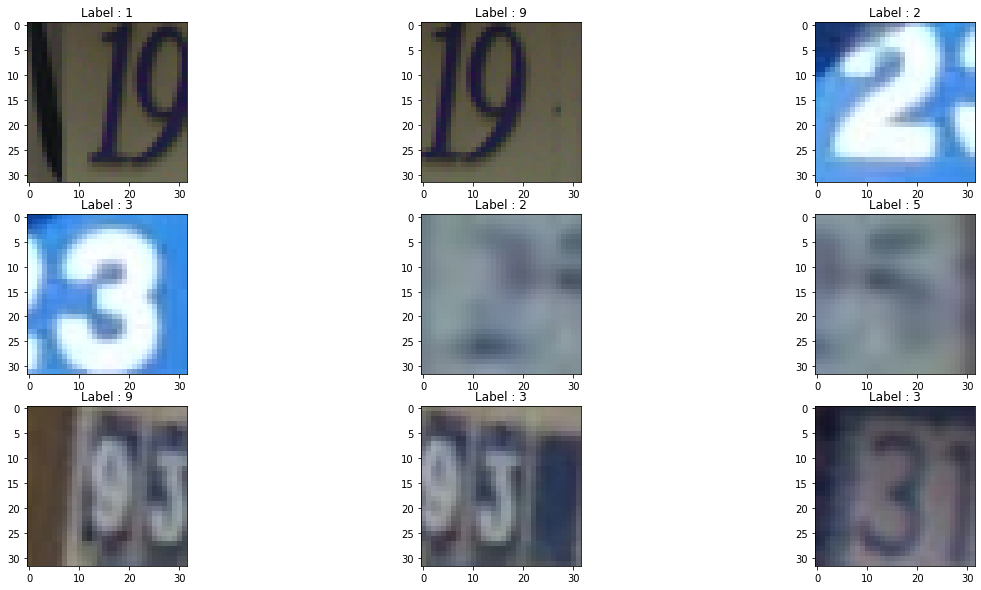

In [ ]:
## SVHN Data set Preparation
svhn_train = datasets.SVHN(         # SVHN Training data set
    root=root,
    split='train',
    download=True,
    transform=transforms.ToTensor()
)
svhn_test = datasets.SVHN(          # SVHN Test data set
    root=root,
    split='test',
    download=True,
    transform=transforms.ToTensor()
)

collected_y = []
for idx in range(len(svhn_train)):
  each_x, each_y = svhn_train[idx]
  collected_y.append(each_y)
print(f"Input Length = {len(svhn_train)}   Class labels = {np.unique(np.array(collected_y))}")
plot_image_svhn(data=svhn_train)

## **① Training | Validation Dataset Split**  
- MNIST Dataset의 경우 입력으로 들어온 "valid_ratio" arg를 통해 Training/Valid Split 수행  
- SVHN Dataset의 경우 "Pytorch의 Random Split"을 통해 Training/Valid Split 수행

In [ ]:
## Definition of MNIST Dataset Class
class Mnist_Dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass
  
  def __len__(self):
      return len(self.data)
  
  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y


## Training and Validation data set Split for MNIST
def train_valid_split(dataset, valid_ratio=0.1):
  valid_len = int(len(dataset) * valid_ratio)

  train_data = dataset.data[:-valid_len].numpy()
  valid_data = dataset.data[-valid_len:].numpy()

  train_targets = dataset.targets[:-valid_len]
  valid_targets = dataset.targets[-valid_len:]

  train = Mnist_Dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = Mnist_Dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

mnist_train, mnist_valid = train_valid_split(dataset=mnist_train)


## Training and Validation data set Split for SVHN
random_seed = 0
torch.manual_seed(random_seed)      # random_seed = 0으로 고정하여 항상 같은 random값 도출

valid_size = int(len(svhn_train) * 0.1)
train_size = len(svhn_train) - valid_size
svhn_train, svhn_valid = random_split(svhn_train, [train_size, valid_size])


## Definition of Total Image data set dictionary
image_datasets = {}
image_datasets['mnist'] = {"train" : mnist_train, "valid" : mnist_valid, "test" : mnist_test}
image_datasets['svhn'] = {"train" : svhn_train, "valid" : svhn_valid, "test" : svhn_test}

for idx in image_datasets.keys():
  print(f"Length of {idx} : Train -- {len(image_datasets[idx]['train'])} Valid -- {len(image_datasets[idx]['valid'])} Test -- {len(image_datasets[idx]['test'])}")
print()


## Definition of Dataset Loader for different kinds of dataset
loaders = {}
for idx in image_datasets.keys():
  loaders[idx] = {set_type : DataLoader(dataset=image_datasets[idx][set_type],
                                        batch_size=64,
                                        shuffle=set_type == "train",
                                        drop_last=True) for set_type in ["train", "valid", "test"]}
loaders

Length of mnist : Train -- 54000 Valid -- 6000 Test -- 10000
Length of svhn : Train -- 65932 Valid -- 7325 Test -- 26032



{'mnist': {'train': <torch.utils.data.dataloader.DataLoader at 0x7fd39aa063d0>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7fd39aa065d0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7fd39aa06a10>},
 'svhn': {'train': <torch.utils.data.dataloader.DataLoader at 0x7fd39aa06dd0>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7fd39aa068d0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7fd39aa060d0>}}

## **② AI Model Building + Trainer Class Definition**  
> MNIST Classifier의 경우 Feature Visualization을 위해 각각의 Convolutional Layer를 `nn.Sequential`로 묶지 않고, **따로 정의한 후 Forward Pass function을 통해 학습/추론 진행**

In [ ]:
## CNN Classifier Modeling for MNIST Image Data set
class CNNMNISTClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)    # nn.Conv2d : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d
    self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                                  # nn.Maxpool2d : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(3*3*32, 32)
    self.fc2 = nn.Linear(32, 10)

    # self.model = nn.Sequential(
    #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
    #     nn.ReLU(),
    #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    #     nn.Conv2d(32, 32, 3, stride=1, padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2, stride=2, padding=0),
    #     nn.Conv2d(32, 32, 3, stride=1, padding=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(2, stride=2, padding=0),
    #     nn.Flatten(),
    #     nn.Linear(3*3*32, 32),
    #     nn.ReLU(),
    #     nn.Linear(32, 10),
    # )
  
  def forward(self, x, visualize_filter=False):       # CNN Layer들의 parameter 구성 = (Batch) * (Channels) * (Width) * (Height)
    conv1 = self.conv1(x)                             # Spatial size = {(28 + 4 - 5) / 1} + 1 = 28 => 1 * 32 * 28 * 28
    _conv1 = self.pool(self.relu(conv1))              # Spatial size = 28 / 2 = 14 => 1 * 32 * 14 * 14
    conv2 = self.conv2(_conv1)                        # Spatial size = {(14 + 2 - 3) / 1} + 1 = 14 => 1 * 32 * 14 * 14
    _conv2 = self.pool(self.relu(conv2))              # Spatial size = 14 / 2 = 7 => 1 * 32 * 7 * 7
    conv3 = self.conv3(_conv2)                        # Spatial size = {(7 + 2 - 3) / 1} + 1 = 7 => 1 * 32 * 7 * 7
    _conv3 = self.pool(self.relu(conv3))              # Spatial size = 7 / 2 = 3(작은 정수형) => 1 * 32 * 3 * 3
    conv3_vec = self.flatten(_conv3)                  # Spatial size(Vectorized) => 1 * 288
    fc1 = self.fc1(conv3_vec)                         # Spatial size(Vectorized) => 1 * 32
    out = self.fc2(self.relu(fc1))                    # Spatial size(Vectorized) => 1 * 10
                                                      # nn.Sequential을 사용할 경우 : out = self.mode(x)
    if not visualize_filter == True:
      return out
    else:
      return conv1, conv2, conv3, out


## CNN Classifier Modeling for SVHN Image Data set
class CNNSVHNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),       # ① 첫번째 Conv Block : Output = 64 X 16 X 16
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),     # kernel_size=2, stride=2, pading=0

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),     # ② 두번째 Conv Block : Output = 128 X 8 X 8
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),    # ③ 세번째 Conv Block : Output = 256 X 4 X 4
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),                                               # ④ 마지막 FC Layer(vectorize) : Output = 10개의 features
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  
  def forward(self, x, visualize_filter=False):
    out = self.model(x)
    return out


## Define Trainer of CNN Classifier Model
class CNNTrainer(nn.Module):
  def __init__(self, model, loaders, opt='sgd', lr=0.001, has_scheduler=False, device='cuda'):
    super().__init__()

    self.model = model
    self.loss = nn.CrossEntropyLoss()

    self.train_loader = loaders["train"]
    self.valid_loader = loaders["valid"]
    self.test_loader = loaders["test"]

    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()
    
    self.device = device
    pass
  
  def _get_optimizer(self, opt, lr=0.001):    # 학습에 사용할 Optimizer 정의
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adagrad":
      self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
    elif opt == "adadelta":
      self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
    elif opt == "rmsprop":
      self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"Inputted Optimizer {opt} is not Supported")
  
  def _get_scheduler(self, algo):                   # 학습에 사용할 Learning rate Scheduler 정의
    if algo == "steplr":
      self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)    # 학습의 총 epoch에서 step_size마다 gamma의 비율로 learning rate를 순차적으로 줄임
    elif algo == "lambdalr":
      self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)   # 학습 도중 lr_lambda에 정의한 function에 의해 learning rate을 순차적으로 줄임

  def train(self, max_epochs=10, disp_epochs=5):             # 학습 결과 도출 Process, 총 학습 round 수(epoch 수) = max_epochs
    print("======= Train Start =======")
    start_time = time.time()
    history = {"Train Loss" : [], "Train Acc" : [], "Valid Loss" : [], "Valid Acc" : []}    # 매 학습 epoch마다 Loss와 Accuracy를 저장할 dictionary 정의

    for epoch in range(max_epochs):
      train_loss, train_acc = self._train_epoch()
      valid_loss, valid_acc = self._valid_epoch()

      history["Train Loss"].append(train_loss)
      history["Train Acc"].append(train_acc)
      history["Valid Loss"].append(valid_loss)
      history["Valid Acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()     # has_scheduler=True이면 사전에 정의한 Learning rate Scheduler를 지정한 step_size마다 수행

      if epoch % disp_epochs == 0:
        print(f"{epoch}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Train Acc : {train_acc:>6f}, Valid Loss : {valid_loss:>6f}, Valid Acc : {valid_acc:>6f}, Time : {time.time() - start_time:>3f}")
        start_time = time.time()

    self.plot_history(history)

  def _train_epoch(self):       # Training Process
    train_epoch_loss, train_epoch_acc = 0, 0
    self.model.train()                          # model.train() => model을 Training mode로 전환

    for (x, y) in self.train_loader:            
      x = x.to(device=self.device)              # Numpy array가 된 Input image data를 GPU로
      y = y.to(device=self.device)              # Target class label을 GPU로

      y_hat = self.model(x)                     # ① 사전에 정의한 ANNImageMNISTClassifier model로 학습 진행 => Forward Pass, y_hat => Forward Pass의 예측 결과값
      loss = self.loss(y_hat, y)                # ② CrossEntropyLoss(for Classification Task)로 Loss function 계산

      self.optimizer.zero_grad()                # ② Forward Pass 과정에서 학습한 parameter들 -> Backward Pass로 update 진행
      loss.backward()
      self.optimizer.step()

      train_epoch_loss += loss.to("cpu").item()
      train_epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()
    
    train_epoch_loss /= len(self.train_loader)
    train_epoch_acc /= len(self.train_loader)

    return train_epoch_loss, train_epoch_acc

  def _valid_epoch(self):       # Validation Process
    valid_epoch_loss, valid_epoch_acc = 0, 0
    self.model.eval()                           # model.eval() => model을 Validation mode로 전환, Validation 과정에서 사용하지 않을 layer들을 non-activate 상태로 전환

    with torch.no_grad():                       # model에 Loss function의 gradient를 계산하지 않음
      for (x, y) in self.valid_loader:
        x = x.to(device=self.device)
        y = y.to(device=self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        valid_epoch_loss += loss.to("cpu").item()
        valid_epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    valid_epoch_loss /= len(self.valid_loader)
    valid_epoch_acc /= len(self.valid_loader)

    return valid_epoch_loss, valid_epoch_acc

  def plot_history(self, history):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["Train Loss"], color="red", label="Train Loss")
    ax.plot(history["Valid Loss"], color="orange", label="Valid Loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["Train Acc"], color="red", label="Train Accuracy")
    ax.plot(history["Valid Acc"], color="orange", label="Valid Accuracy")
    ax.set_title("Accuracy")
    ax.legend()

    fig.show()

  def test(self):       # Test Process
    print("======= Test Start =======")
    start_time = time.time()
    test_epoch_loss, test_epoch_acc = 0, 0
    self.model.eval()

    with torch.no_grad():
      for (x, y) in self.test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        test_epoch_loss += loss.to("cpu").item()
        test_epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    test_epoch_loss /= len(self.test_loader)
    test_epoch_acc /= len(self.test_loader)

    print(f"Test loss: {test_epoch_loss:>6f}, Test acc: {test_epoch_acc:>3f}, Test time : {time.time() - start_time:>3f}")

## **③ Training + Validation + Test CNN Model for each Dataset and Save/Load Model**

### *MNIST Dataset Training + Test Process and Save/Load CNN Model*

======= Train Start =======
0/10 Epoch ==> Train Loss : 0.264574, Train Acc : 0.916222, Valid Loss : 0.075562, Valid Acc : 0.978663, Time : 10.668344
1/10 Epoch ==> Train Loss : 0.069196, Train Acc : 0.977906, Valid Loss : 0.055449, Valid Acc : 0.984207, Time : 4.181117
2/10 Epoch ==> Train Loss : 0.049758, Train Acc : 0.984653, Valid Loss : 0.044140, Valid Acc : 0.987231, Time : 4.239784
3/10 Epoch ==> Train Loss : 0.040585, Train Acc : 0.987433, Valid Loss : 0.039904, Valid Acc : 0.989079, Time : 4.812512
4/10 Epoch ==> Train Loss : 0.034567, Train Acc : 0.988620, Valid Loss : 0.032900, Valid Acc : 0.991095, Time : 4.235627
5/10 Epoch ==> Train Loss : 0.030264, Train Acc : 0.990121, Valid Loss : 0.038098, Valid Acc : 0.988575, Time : 5.054440
6/10 Epoch ==> Train Loss : 0.024796, Train Acc : 0.991604, Valid Loss : 0.031388, Valid Acc : 0.991095, Time : 4.205411
7/10 Epoch ==> Train Loss : 0.022279, Train Acc : 0.992883, Valid Loss : 0.036828, Valid Acc : 0.988743, Time : 4.167980
8/1

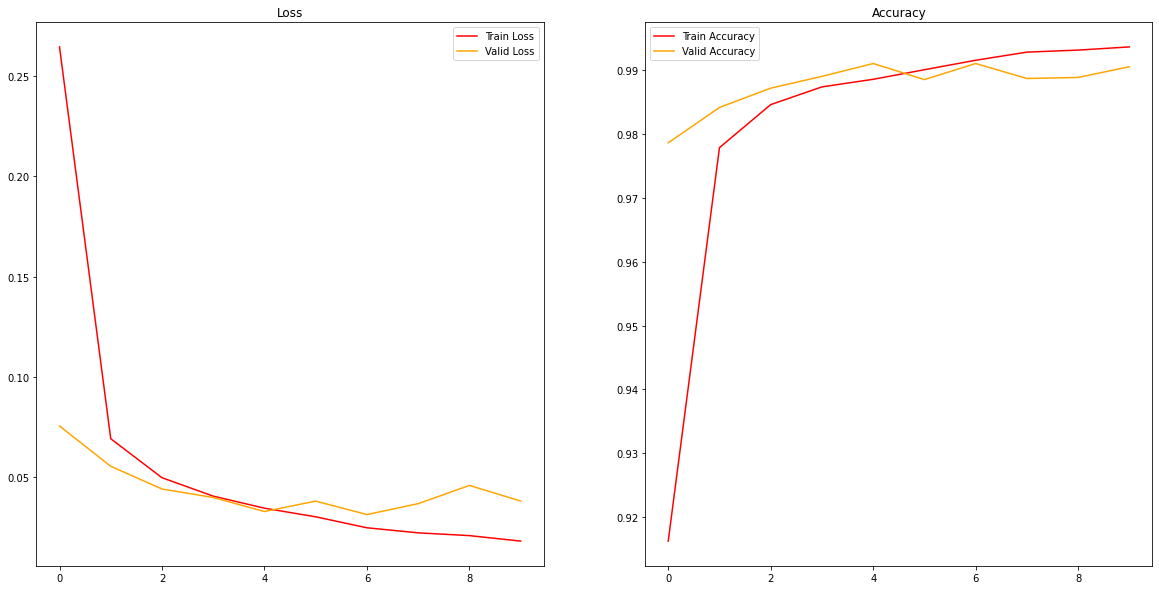

In [ ]:
## MNIST Training + Test Process
device = "cuda"
mnist_model = CNNMNISTClassifier(n_class=10)
mnist_trainer = CNNTrainer(model=mnist_model, loaders=loaders["mnist"], opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)

start_time = time.time()
mnist_trainer.train(max_epochs=10, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

mnist_trainer.test()

In [ ]:
## MNIST CNN Model Save
for param_tensor in mnist_model.state_dict():
  print(f"{param_tensor} : \t {mnist_model.state_dict()[param_tensor].size()}")   # CNN model의 state dictionary 출력 -> 각 layer에서의 parameter들

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

torch.save(mnist_model.state_dict(), os.path.join(model_dir, "MNIST_CNN_Classifier.pth"))

conv1.weight : 	 torch.Size([32, 1, 5, 5])
conv1.bias : 	 torch.Size([32])
conv2.weight : 	 torch.Size([32, 32, 3, 3])
conv2.bias : 	 torch.Size([32])
conv3.weight : 	 torch.Size([32, 32, 3, 3])
conv3.bias : 	 torch.Size([32])
fc1.weight : 	 torch.Size([32, 288])
fc1.bias : 	 torch.Size([32])
fc2.weight : 	 torch.Size([10, 32])
fc2.bias : 	 torch.Size([10])


In [ ]:
## MNIST CNN Model Load and Check its Performance
device = "cuda"                                             # ① 먼저 학습하지 않은 상태로 CNN Trainer를 통해 Test dataset 성능 측정
mnist_cnn_load = CNNMNISTClassifier(n_class=10)
mnist_unloaded_trainer = CNNTrainer(model=mnist_cnn_load, loaders=loaders["mnist"], opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
mnist_unloaded_trainer.test()

model_path = os.path.join(model_dir, "MNIST_CNN_Classifier.pth")
print(model_path)
print()

mnist_cnn_load.load_state_dict(torch.load(model_path))      # ② 이전에 학습된 Model의 parameter들을 Load한 후, Test dataset 성능 측정
mnist_cnn_load.eval()

mnist_loaded_trainer = CNNTrainer(model=mnist_cnn_load, loaders=loaders["mnist"], opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
mnist_loaded_trainer.test()

======= Test Start =======
Test loss: 2.303773, Test acc: 0.113482, Test time : 0.903903
/content/drive/MyDrive/Colab Notebooks/model/MNIST_CNN_Classifier.pth

======= Test Start =======
Test loss: 0.035171, Test acc: 0.989583, Test time : 0.914971


### *SVHN Dataset Training + Test Process*

======= Train Start =======
0/10 Epoch ==> Train Loss : 1.716666, Train Acc : 0.383632, Valid Loss : 0.652752, Valid Acc : 0.791255, Time : 23.904431
1/10 Epoch ==> Train Loss : 0.431056, Train Acc : 0.867582, Valid Loss : 0.361570, Valid Acc : 0.889803, Time : 24.319509
2/10 Epoch ==> Train Loss : 0.305244, Train Acc : 0.908920, Valid Loss : 0.305530, Valid Acc : 0.910499, Time : 23.902195
3/10 Epoch ==> Train Loss : 0.245173, Train Acc : 0.926638, Valid Loss : 0.285007, Valid Acc : 0.912966, Time : 24.394760
4/10 Epoch ==> Train Loss : 0.207637, Train Acc : 0.939366, Valid Loss : 0.271390, Valid Acc : 0.922012, Time : 23.911829
5/10 Epoch ==> Train Loss : 0.176607, Train Acc : 0.948559, Valid Loss : 0.284745, Valid Acc : 0.921190, Time : 23.869560
6/10 Epoch ==> Train Loss : 0.153195, Train Acc : 0.955431, Valid Loss : 0.286582, Valid Acc : 0.923383, Time : 24.484774
7/10 Epoch ==> Train Loss : 0.127416, Train Acc : 0.962227, Valid Loss : 0.331065, Valid Acc : 0.918448, Time : 24.556

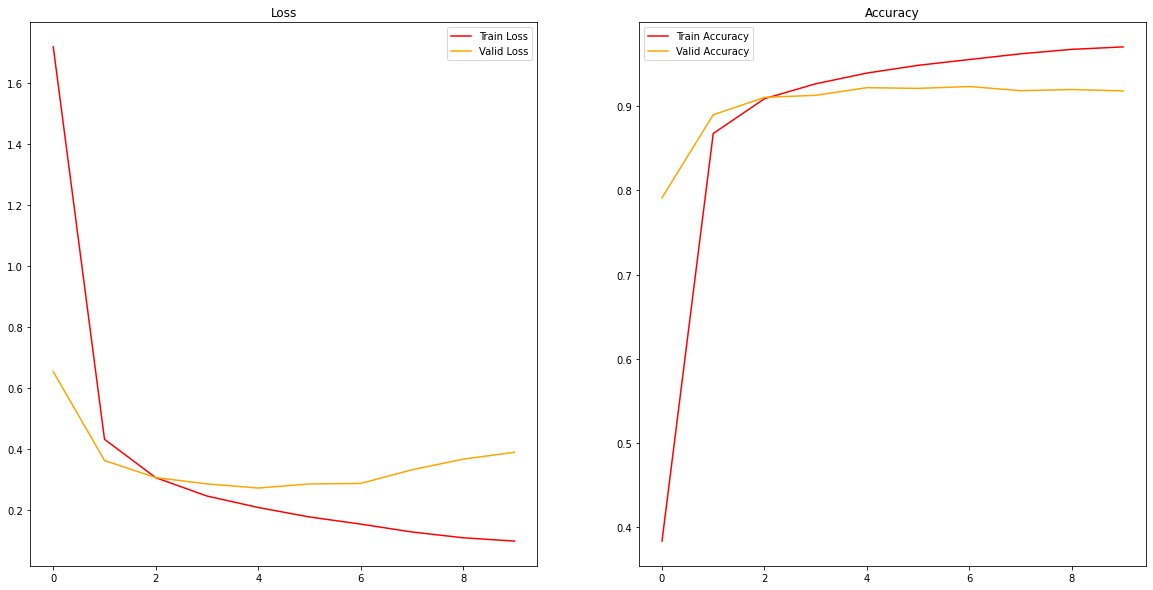

In [ ]:
## SVHN Training + Test Process
device = "cuda"
svhn_model = CNNSVHNClassifier()
svhn_trainer = CNNTrainer(model=svhn_model, loaders=loaders["svhn"], opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)

start_time = time.time()
svhn_trainer.train(max_epochs=10, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

svhn_trainer.test()

In [ ]:
## SVHN CNN Model Save
for param_tensor in svhn_model.state_dict():
  print(f"{param_tensor} : \t {svhn_model.state_dict()[param_tensor].size()}")   # CNN model의 state dictionary 출력 -> 각 layer에서의 parameter들

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "model")
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

torch.save(svhn_model.state_dict(), os.path.join(model_dir, "SVHN_CNN_Classifier.pth"))

model.0.weight : 	 torch.Size([32, 3, 3, 3])
model.0.bias : 	 torch.Size([32])
model.2.weight : 	 torch.Size([64, 32, 3, 3])
model.2.bias : 	 torch.Size([64])
model.5.weight : 	 torch.Size([128, 64, 3, 3])
model.5.bias : 	 torch.Size([128])
model.7.weight : 	 torch.Size([128, 128, 3, 3])
model.7.bias : 	 torch.Size([128])
model.10.weight : 	 torch.Size([256, 128, 3, 3])
model.10.bias : 	 torch.Size([256])
model.12.weight : 	 torch.Size([256, 256, 3, 3])
model.12.bias : 	 torch.Size([256])
model.16.weight : 	 torch.Size([512, 4096])
model.16.bias : 	 torch.Size([512])
model.18.weight : 	 torch.Size([512, 512])
model.18.bias : 	 torch.Size([512])
model.20.weight : 	 torch.Size([10, 512])
model.20.bias : 	 torch.Size([10])


In [ ]:
## SVHN CNN Model Load and Check its Performance
device = "cuda"                                             # ① 먼저 학습하지 않은 상태로 CNN Trainer를 통해 Test dataset 성능 측정
svhn_cnn_load = CNNSVHNClassifier(n_class=10)
svhn_unloaded_trainer = CNNTrainer(model=svhn_cnn_load, loaders=loaders["svhn"], opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
svhn_unloaded_trainer.test()

model_path = os.path.join(model_dir, "SVHN_CNN_Classifier.pth")
print(model_path)
print()

svhn_cnn_load.load_state_dict(torch.load(model_path))       # ② 이전에 학습된 Model의 parameter들을 Load한 후, Test dataset 성능 측정
svhn_cnn_load.eval()

svhn_loaded_trainer = CNNTrainer(model=svhn_cnn_load, loaders=loaders["svhn"], opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
svhn_loaded_trainer.test()

======= Test Start =======
Test loss: 2.302406, Test acc: 0.077586, Test time : 5.204962
/content/drive/MyDrive/Colab Notebooks/model/SVHN_CNN_Classifier.pth

======= Test Start =======
Test loss: 0.377172, Test acc: 0.922375, Test time : 5.133668
